#### import Python libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences, MOT16Sequence
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (
    plot_sequence,
    evaluate_mot_accums,
    get_mot_accum,
    evaluate_obj_detect,
    obj_detect_transforms,
)
from pathlib import Path
import motmetrics as mm

mm.lap.default_solver = "lap"
import itertools
import copy


/tmp/ipykernel_10225/2942962264.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
seed = 735
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.


# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).


## Configuration

In [5]:
obj_detect_model_file = os.path.join(root_dir, "models/faster_rcnn_fpn.model")
obj_detect_nms_thresh = 0.3


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(
    obj_detect_model_file, map_location=lambda storage, loc: storage
)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)


/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Multi-object tracking

provide simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union. Note that the output bounding boxes of the detection network are of format (x1, y1, x2, y2). Hence, we need to reformulate them to be used for the iou_matrix computation with py-motmetrics to format (x1, y1, w, h).

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [7]:
seq_name = "MOT16-02"
data_dir = os.path.join(root_dir, "data/MOT16")
output_dir = os.path.join(root_dir, "output")


In [8]:
def ltrb_to_ltwh(ltrb_boxes):
    ltwh_boxes = copy.deepcopy(ltrb_boxes)
    ltwh_boxes[:, 2] = ltrb_boxes[:, 2] - ltrb_boxes[:, 0]
    ltwh_boxes[:, 3] = ltrb_boxes[:, 3] - ltrb_boxes[:, 1]

    return ltwh_boxes


In [9]:
seq = MOT16Sequence(data_dir, seq_name=seq_name)


# Check single batch

In [11]:
seq_it = iter(seq)


In [12]:
single_frame = next(seq_it)
print(f"single_frame_keys = {(single_frame).keys()}")

print(f"frame shape = {single_frame['img'].shape}")
print(f"frame img_path = {single_frame['img_path']}")
print(f"frame vis  = {single_frame['vis'].keys()}")
print(f"frame vis  = {single_frame['vis'][8]}")


single_frame_keys = dict_keys(['img', 'img_path', 'gt', 'vis'])
frame shape = torch.Size([3, 1080, 1920])
frame img_path = ../data/MOT16/train/MOT16-02/img1/000001.jpg
frame vis  = dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])
frame vis  = 0.51351


In [13]:
print(f"frame gt  = {single_frame['gt'].keys()}")
print(f"frame gt  = {single_frame['gt'][3]}")
print(f"frame gt  = {single_frame['gt'][8]}")


frame gt  = dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])
frame gt  = [585. 446. 669. 708.]
frame gt  = [1415.  430. 1598.  765.]


# Track
object that stores for each box score and track_id belonging (through all frames)

class Track(object):

    """This class contains all necessary for every individual track."""

	def __init__(self, box, score, track_id):
		self.id = track_id
		self.box = box
		self.score = score



# Tracker
- Receives neural network input - detector
- reset - resets the accumulated detections.
- add - creates a new track object with the new track_id
- data_association - method that defines how to process the new frame in relation to the previous one and how to interpret the new boxes

# var 1: new img = new tracks

In [14]:
print(f"check how tracker work on single sequences of frames = {seq_name}")
print(f"in sequence = {seq_name} N frames =  {len(seq)}")


check how tracker work on single sequences of frames = MOT16-02
in sequence = MOT16-02 N frames =  600


In [15]:
empty_tracker = Tracker(obj_detect)


sequence - dataset, each element of which is a dict and contains

- image tensor
- image path
- gt_bbox bbox_id - [x,y,x,y]
- visibility of persons above which they are selected

### Create short seq = 10 


In [19]:
empty_tracker.reset()
print(f"Tracking: {seq}")
data_loader = DataLoader(seq, batch_size=1, shuffle=False)
firstn_loader = itertools.islice(data_loader, 10)
for frame in tqdm(firstn_loader):
    empty_tracker.step(frame)

results = empty_tracker.get_results()
print(f"Tracks found: {len(results)}")


Tracking: MOT16-02


10it [00:00, 12.27it/s]

Tracks found: 162


In [20]:
results.keys()


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])

In [21]:
results[0], results[140]


({0: array([584.55145   , 445.04907   , 669.4421    , 704.5543    ,
           0.99999714], dtype=float32)},
 {8: array([546.8485    , 462.71848   , 580.3655    , 555.316     ,
           0.99948585], dtype=float32)})

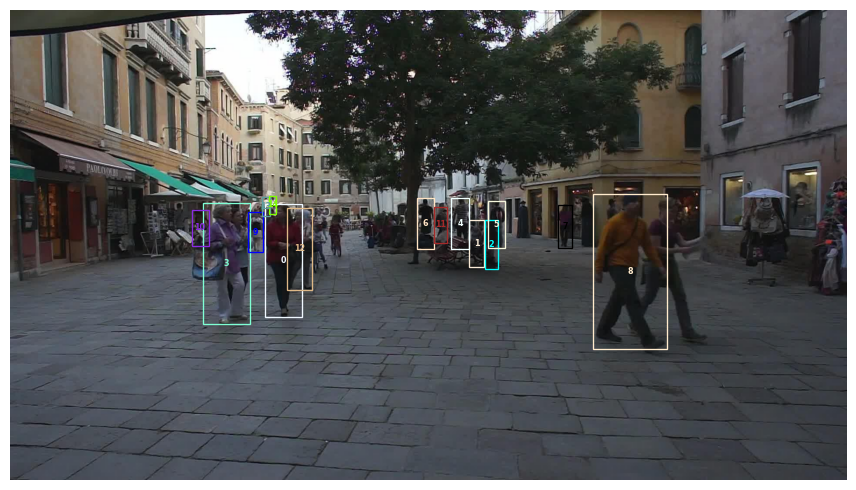

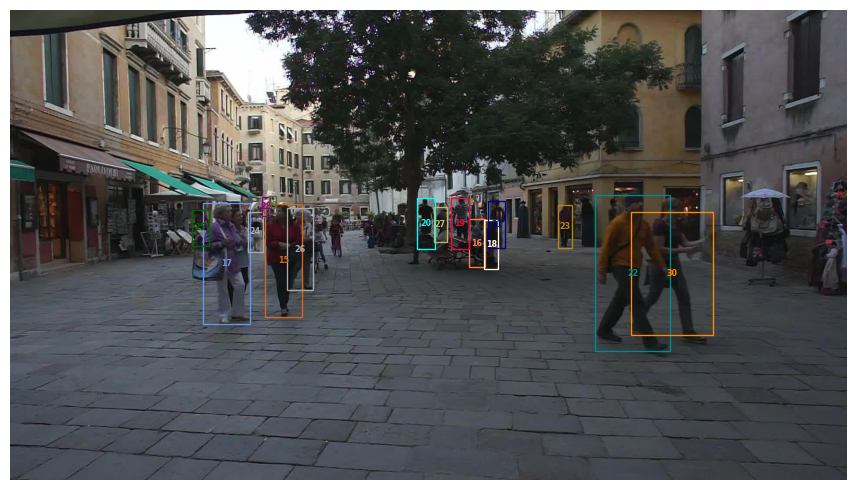

In [22]:
plot_sequence(results, seq, first_n_frames=2)


## on each frame - new detections, no tracking between frames

# Provide tracking base on IoU

In [29]:
# tracker
class TrackerIoUAssignment(Tracker):
    def data_association(self, boxes, scores):
        # self.im_index - index of current proceeded image
        # num existing tracks = self.tracks = 0 at first step
        # new bboxes form new frame = boxes
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)

            iou_track_boxes = ltrb_to_ltwh(track_boxes)
            iou_boxes = ltrb_to_ltwh(boxes)
            distance = mm.distances.iou_matrix(
                iou_track_boxes, iou_boxes.numpy(), max_iou=0.5
            )
            # distance.shape = [num existing tracks,num new bboxes]
            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                # If there are no matching boxes for this track = all nans in row
                # we remove the track from tracking
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            # as self.tracks is empty add all bboxes as start of new tracks"
            self.add(boxes, scores)
            # after add all bboxes self.track is not empty "


tracker = TrackerIoUAssignment(obj_detect)


In [30]:
tracker.reset()
print(f"Tracking: {seq}")
data_loader = DataLoader(seq, batch_size=1, shuffle=False)
firstn_loader = itertools.islice(data_loader, 3)
for frame in tqdm(firstn_loader):
    tracker.step(frame)

results = tracker.get_results()
print(f"Tracks found: {len(results)}")


Tracking: MOT16-02


3it [00:00, 11.02it/s]

Tracks found: 17


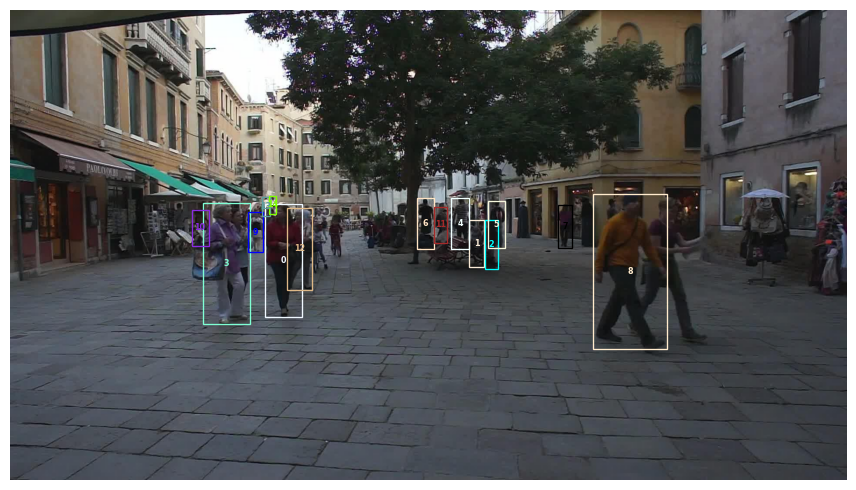

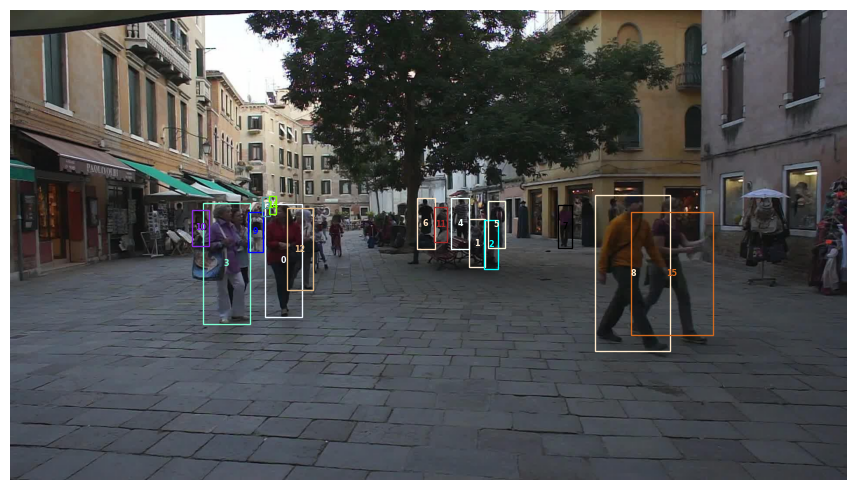

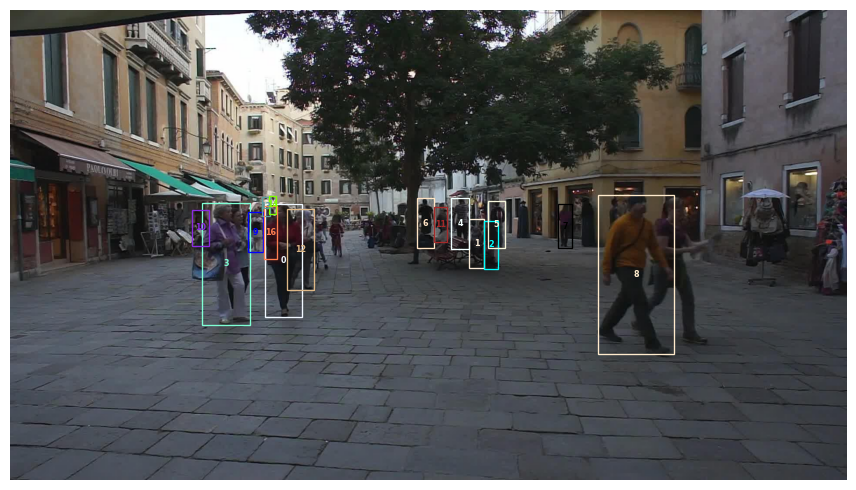

In [35]:
plot_sequence(results, seq, first_n_frames=3)


### result: now bboxes have same ids on different frames

## Run tracker at all sequences

In [39]:
sequences = MOT16Sequences(seq_name, data_dir)


in MOT16 dataset
sequences ['MOT16-02']


In [40]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    # seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums, [str(s) for s in sequences if not s.no_gt], generate_overall=True
    )


Tracking: MOT16-02


100%|████████████████████████████████████████████| 600/600 [00:48<00:00, 12.25it/s]


Tracks found: 357
Runtime for MOT16-02: 56.8 s.
Runtime for all sequences: 56.8 s.
          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP   FN IDs   FM  MOTA  MOTP IDt IDa IDm
MOT16-02 40.5% 57.4% 31.2% 52.3% 96.1% 62 12 37 13 395 8870 200  208 49.1% 0.090  15 188   4
OVERALL  40.5% 57.4% 31.2% 52.3% 96.1% 62 12 37 13 395 8870 200  208 49.1% 0.090  15 188   4


The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT16-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT16-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT16-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT16-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT16-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT16-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT16-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

focus on improving both `MOTA` and `IDF1`.

# Check in details distance matrix and track assotiation

In [45]:
distance = np.matrix(
    [
        [np.nan, np.nan, np.nan, np.nan, np.nan],
        [0.01, np.nan, np.nan, np.nan, np.nan],
        [np.nan, 0.02, np.nan, np.nan, np.nan],
        [np.nan, np.nan, np.nan, np.nan, np.nan],
        [np.nan, np.nan, 0.02, np.nan, np.nan],
        [np.nan, np.nan, 0.01, 0.3, np.nan],
        [np.nan, np.nan, np.nan, 0.03, np.nan],
    ]
)
# num rows = num old(existing on frame t-1) tracks
# less is better -> 0 when the rectangles overlap perfectly and 1 when the overlap is zero.
# np.nan  if there is no overlap above the iou treshold
distance


matrix([[ nan,  nan,  nan,  nan,  nan],
        [0.01,  nan,  nan,  nan,  nan],
        [ nan, 0.02,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan],
        [ nan,  nan, 0.02,  nan,  nan],
        [ nan,  nan, 0.01, 0.3 ,  nan],
        [ nan,  nan,  nan, 0.03,  nan]])

In [51]:
tracks = [i for i in range(distance.shape[0])]
print("exiting tracks indexes on frame t-1", tracks)


exiting tracks indexes on frame t-1 [0, 1, 2, 3, 4, 5, 6]


In [52]:
remove_track_ids = []
for t, dist in zip(tracks, distance):
    # if there is no connection between the existing bbox and the new ones,
    # then in the distance matrix all values = np.nan
    # such a track is considered completed and will not be tracked further
    if np.isnan(dist).all():
        print(f"all nans for existing track {t}")
        remove_track_ids.append(t)
    else:
        match_id = np.nanargmin(dist)
        print(f"for old track = {t} new bbox match_id = {match_id}")
        # t.box = boxes[match_id]
new_tracks = [t for t in tracks if t not in remove_track_ids]


all nans for existing track 0
for old track = 1 new bbox match_id = 0
for old track = 2 new bbox match_id = 1
all nans for existing track 3
for old track = 4 new bbox match_id = 2
for old track = 5 new bbox match_id = 2
for old track = 6 new bbox match_id = 3


In [53]:
print("tracks indexes after proceed one frame:", new_tracks)


tracks indexes after proceed one frame: [1, 2, 4, 5, 6]
